# Cohort Case Study 1

In [29]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager

#SEED = 42
SEED = None

def _create_country_df(samples: int, sectors: dict, country_name: str):
    df = None
    for key in sectors.keys():
        size = int(samples * sectors[key]["prob_occur"])
        invest = np.random.uniform(low=sectors[key]["min"], high=sectors[key]["max"], size=size)
        min_invest = min(invest)
        max_invest = max(invest)
        range_invest = max_invest - min_invest
        bankrupt_th = sectors[key]["prob_success"] * range_invest
        bankrupt = []
        for i in range(invest.shape[0]):
            if invest[i] > bankrupt_th:
                bankrupt.append(0)
            else:
                bankrupt.append(1)
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            bankrupt[ind] = int(not bankrupt[ind])
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            invest[ind] = np.nan
        
        country_col = [country_name for _ in range(size)]
        sector_col = [key for _ in range(size)]
        df_sector = pd.DataFrame({
            "investment":invest,
            "sector":sector_col,
            "country":country_col,
            "bankrupt":bankrupt
        })
        
        if df is None:
            df = df_sector
        else:
            df = pd.concat([df, df_sector], axis=0)
    return df

In [30]:
def create_df_multiple_distributions(samples: list):
    np.random.seed(SEED)
    random.seed(SEED)
    sectors_c1 = {
        "s1": {"prob_occur":0.2, "prob_success":0.8, "min":20000, "max":100000},
        "s2": {"prob_occur":0.4, "prob_success":0.6, "min":1000, "max":15000},
        "s3": {"prob_occur":0.1, "prob_success":0.9, "min":1000000, "max":10000000},
        "s4": {"prob_occur":0.3, "prob_success":0.7, "min":4000000, "max":900000000},
    }
    sectors_c2 = {
        "s1": {"prob_occur":0.05, "prob_success":0.6, "min":1000, "max":5000},
        "s2": {"prob_occur":0.6, "prob_success":0.9, "min":100000, "max":1500000},
        "s3": {"prob_occur":0.2, "prob_success":0.5, "min":50000, "max":300000},
        "s4": {"prob_occur":0.15, "prob_success":0.8, "min":1000000, "max":10000000},
    }
    countries = {
        "A":{"sectors":sectors_c1, "sample_rate":0.8},
        "B":{"sectors":sectors_c2, "sample_rate":0.2}
    }
    df = None
    for key in countries.keys():
        n_sample = int(samples * countries[key]["sample_rate"])
        df_c = _create_country_df(n_sample, countries[key]["sectors"], key)
        if df is None:
            df = df_c
        else:
            df = pd.concat([df, df_c], axis=0)
    
    idx = pd.Index([i for i in range(df.shape[0])])
    df = df.set_index(idx)
    return df

In [31]:
df = create_df_multiple_distributions(3000)
df

,investment,sector,country,bankrupt
0,6.952551e+04,s1,A,0
1,6.275074e+04,s1,A,1
2,2.552050e+04,s1,A,1
3,7.129769e+04,s1,A,0
4,4.032000e+04,s1,A,1
...,...,...,...,...
2995,5.439663e+06,s4,B,1
2996,1.310433e+06,s4,B,1
2997,9.712284e+06,s4,B,1
2998,7.340829e+06,s4,B,0


In [32]:
subset = df.query("sector == 's1' and investment < 60000")
subset['bankrupt'].value_counts(normalize=True)

1    0.869388
0    0.130612
Name: bankrupt, dtype: float64

No columns specified for encoding. These columns have been automatically identfied as the following:
['sector', 'country']
No columns specified for imputation. These columns have been automatically identified:
['investment']
------------
TEST
------------
[[141  36]
 [ 26 247]]


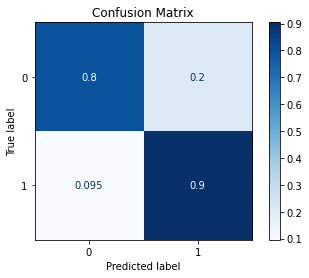

Acuracy: 86.22%

Precision:  0.8585514483400689

Recall:  0.8506860371267151

F1 =  0.8541283252467793

ROC AUC =  0.882628670764264


In [33]:
X_train, X_test, y_train, y_test = dp.split_data(df, label="bankrupt", test_size=0.15)
class_list = y_train.unique()

model = LGBMClassifier(random_state=SEED)
pipe = Pipeline([
            ("encoder", dp.EncoderOHE()),
            ("imputer", dp.BasicImputer()),
            ("estimator", model),
        ])
pipe.fit(X_train, y_train)
pred = pipe.predict_proba(X_test)

roc, pr, rc, th = dp.evaluate_set(y_test, pred, is_train=False, plot_pr=False, classes=class_list)

No columns specified for imputation. These columns have been automatically identified:
['investment']
No columns specified for imputation. These columns have been automatically identified:
['investment']
No columns specified for encoding. These columns have been automatically identfied as the following:
['sector', 'country']
------------
TEST
------------
[[148  29]
 [ 35 238]]


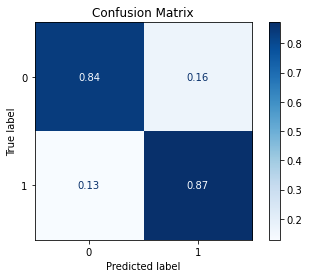

Acuracy: 85.78%

Precision:  0.8500644685945846

Recall:  0.8539765319426336

F1 =  0.8518518518518519

ROC AUC =  0.8877506674116844


In [34]:
model = LGBMClassifier(random_state=SEED)

cht_manager = CohortManager(
    transform_pipe=dp.BasicImputer(),
    cohort_col=["country"]
)

pipe = Pipeline([
            ("imputer", cht_manager),
            ("encoder", dp.EncoderOHE()),
            ("estimator", model),
        ])
pipe.fit(X_train, y_train)
pred = pipe.predict_proba(X_test)

roc, pr, rc, th = dp.evaluate_set(y_test, pred, is_train=False, plot_pr=False, classes=class_list)

No columns specified for encoding. These columns have been automatically identfied as the following:
['sector', 'country']
No columns specified for imputation. These columns have been automatically identified:
['investment']
No columns specified for encoding. These columns have been automatically identfied as the following:
['sector', 'country']
No columns specified for imputation. These columns have been automatically identified:
['investment']
------------
TEST
------------
[[147  30]
 [ 33 240]]


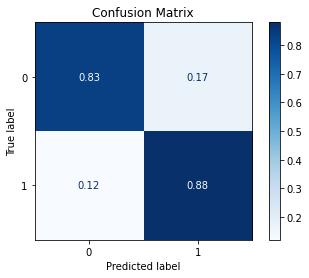

Acuracy: 86.00%

Precision:  0.8527777777777777

Recall:  0.8548146768485752

F1 =  0.8537536561585959

ROC AUC =  0.8726330167008134


In [35]:
model = LGBMClassifier(random_state=SEED)

cht_manager = CohortManager(
    transform_pipe=[dp.EncoderOHE(), dp.BasicImputer(), model],
    cohort_col=["country"]
)
cht_manager.fit(X_train, y_train)
pred = cht_manager.predict_proba(X_test)

roc, pr, rc, th = dp.evaluate_set(y_test, pred, is_train=False, plot_pr=False, classes=class_list)